In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# This data is from the National Household Travel Survey
Trying to create a better version of this: https://nhts.ornl.gov/vehicle-trips

This data is also interesting: https://www.bts.gov/content/us-vehicle-miles

In [2]:
nhts = pd.read_csv('trippub.csv')

In [3]:
nhts.head()

,HOUSEID,PERSONID,TDTRPNUM,STRTTIME,ENDTIME,TRVLCMIN,TRPMILES,TRPTRANS,TRPACCMP,TRPHHACC,...,OBHTNRNT,OBPPOPDN,OBRESDN,DTHTNRNT,DTPPOPDN,DTRESDN,DTEEMPDN,DBHTNRNT,DBPPOPDN,DBRESDN
0,30000007,1,1,1000,1015,15,5.244,3,0,0,...,20,750,300,50,750,300,350,30,300,300
1,30000007,1,2,1510,1530,20,5.149,3,0,0,...,30,300,300,50,1500,750,750,20,750,300
2,30000007,2,1,700,900,120,84.004,6,0,0,...,40,1500,750,50,1500,750,750,20,750,300
3,30000007,2,2,1800,2030,150,81.628,6,0,0,...,20,750,300,40,1500,750,750,40,1500,750
4,30000007,3,1,845,900,15,2.250,3,0,0,...,20,750,300,50,750,300,350,60,750,300


In [4]:
len(nhts)

923572

In [5]:
nhts.DRVR_FLG.value_counts()

 1    611963
 2    188934
-1    122675
Name: DRVR_FLG, dtype: int64

In [6]:
nhts.TRPTRANS.value_counts().head()

3    396931
4    229466
6    108303
1     81288
5     60463
Name: TRPTRANS, dtype: int64

# VMT by trip Distance
From NHTS: 
> How to Calculate: Sum the trip weight (WTTRDFIN) for records in the Trip file where DRVR_FLG = 01 and TRPTRANS = (03,04,05,06,08,09,18)

In [7]:
trips = nhts.loc[nhts.DRVR_FLG.isin([1,]) & nhts.TRPTRANS.isin([3,4,5,6,8,9,18])].copy()
trips.sample(5)

,HOUSEID,PERSONID,TDTRPNUM,STRTTIME,ENDTIME,TRVLCMIN,TRPMILES,TRPTRANS,TRPACCMP,TRPHHACC,...,OBHTNRNT,OBPPOPDN,OBRESDN,DTHTNRNT,DTPPOPDN,DTRESDN,DTEEMPDN,DBHTNRNT,DBPPOPDN,DBRESDN
774528,40511037,2,2,1648,1652,4,1.144,6,0,0,...,50,3000,1500,30,300,50,75,30,1500,750
352632,30388920,1,4,1815,1840,25,5.740,3,0,0,...,70,3000,1500,40,1500,750,750,50,3000,1500
356035,30392732,1,1,800,820,20,5.945,6,0,0,...,30,50,50,30,300,50,25,30,1500,300
471260,30521560,1,5,1445,1454,9,4.264,3,0,0,...,60,3000,1500,20,1500,750,750,50,1500,750
432487,30478064,2,2,742,810,28,10.516,3,0,0,...,0,3000,1500,60,1500,750,750,0,300,300


In [8]:
len(trips)

611342

### Unweighted histogram

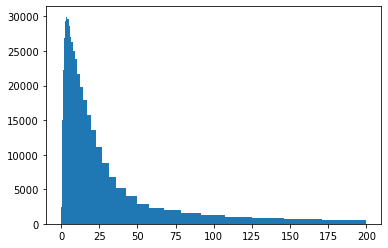

In [9]:
bins = np.logspace(-1, 2.3, 50)

counts,bins,ax = plt.hist(trips.TRPMILES, bins=bins)
# plt.semilogx()

### 'WTTRDFIN' is the weighting factor to get from one trip to total equivalent annual trips in the United States

Funny quote: 
> "Because we did not invite every person and household in the U.S. to participate in the 2017 NHTS, the sample estimate could differ from the result that would have been obtained if we had conducted a census under the exact same circumstances."

In [10]:
trips['US Weighted Trip Counts'] = trips.WTTRDFIN
trips['Normalization Factor'] = trips.WTTRDFIN / trips.WTTRDFIN.mean()

In [11]:
def trip_stats(df):
    """Estimate the weighted mean trip distance and weighted total number of US annual trips"""
    
    trip_distance = (df.WTTRDFIN * df.TRPMILES).mean() / df.WTTRDFIN.mean()
    annual_trips = df.WTTRDFIN.sum()
    
    return trip_distance,int(annual_trips)

In [12]:
bins = np.logspace(-1, 2.3, 50)

In [13]:
bins = [0, 1, 3, 10, 30, np.Inf]

In [14]:
trips['Distance Bin'] = pd.cut(trips['TRPMILES'], bins=bins, right=True)

stats = trips.groupby('Distance Bin').apply(trip_stats)

stats = pd.DataFrame(stats.tolist(), columns=['Trip Distance','Annual Trips'], 
                     index=stats.index)#.map(lambda interval: float(interval.left)))

In [15]:
def range_str(interval):
    
    try: return f'{int(interval.left)}-{int(interval.right)}\nmiles'
    
    except: return f'{int(interval.left)}+\nmiles'

stats['Left'] = stats.index.map(lambda interval: interval.left).astype('float')
stats['Distange Range'] = stats.index.map(range_str).astype('str')
stats['Annual Vehicle Miles Traveled'] = stats['Trip Distance'] * stats['Annual Trips']
stats['Annual Vehicle Miles Traveled (billions)'] = stats['Trip Distance'] * stats['Annual Trips'] / 1E9

In [30]:
axes

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa0f80f8e50>,
      dtype=object)

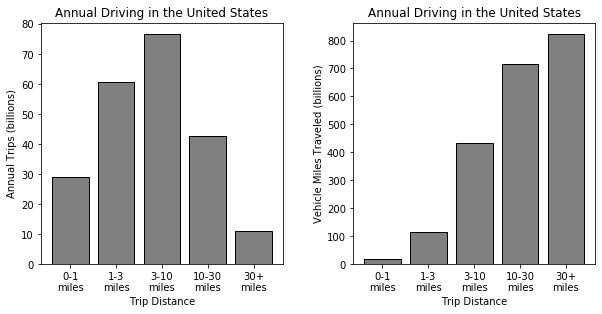

In [49]:
fig,axes = plt.subplots(1, 2, figsize=(9,5))
color = 'grey'

ax = axes[0]
ax.bar(stats['Distange Range'], stats['Annual Trips'] / 1E9, 
        linewidth=1, edgecolor='k', facecolor=color)
ax.set_ylabel('Annual Trips (billions)')
ax.set_xlabel('Trip Distance')
ax.set_title('Annual Driving in the United States')

ax = axes[1]
ax.bar(stats['Distange Range'], stats['Annual Vehicle Miles Traveled (billions)'], 
        linewidth=1, edgecolor='k', facecolor=color)
ax.set_ylabel('Vehicle Miles Traveled (billions)')
ax.set_xlabel('Trip Distance')
ax.set_title('Annual Driving in the United States')

plt.tight_layout(pad=3.0)
plt.savefig('Annual Trips and VMT.png', bbox_inches='tight', alpha=0)

In [18]:
stats

,Trip Distance,Annual Trips,Left,Distange Range,Annual Vehicle Miles Traveled,Annual Vehicle Miles Traveled (billions)
Distance Bin,,,,,,
"(0.0, 1.0]",0.583348,29149758821,0.0,0-1\nmiles,1.700444e+10,17.004443
"(1.0, 3.0]",1.920523,60798730814,1.0,1-3\nmiles,1.167654e+11,116.765358
"(3.0, 10.0]",5.674367,76600310132,3.0,3-10\nmiles,4.346583e+11,434.658267
"(10.0, 30.0]",16.778433,42626749689,10.0,10-30\nmiles,7.152101e+11,715.210069
"(30.0, inf]",73.337766,11211734756,30.0,30+\nmiles,8.222436e+11,822.243575


In [19]:
0.8/2.1

0.38095238095238093

In [20]:
annual_us_vmt = stats['Annual Vehicle Miles Traveled'].sum()
f'{annual_us_vmt / 1E12:.1f} trillion'

'2.1 trillion'

In [21]:
f'{annual_us_vmt / 300E6:.0f} VMT per capita'

'7020 per capita'

<BarContainer object of 5 artists>

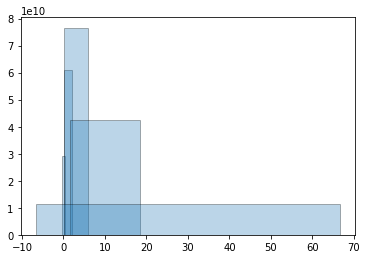

In [22]:
plt.bar(stats.Left, stats['Annual Trips'], 
        width=stats['Trip Distance'],
        linewidth=1, edgecolor='k', alpha=0.3)